In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import prose.datainsights as di
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr  
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

np.random.seed(0)

le = preprocessing.LabelEncoder()

columns = ["Year","Month","Day","DayOfWeek","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Origin","Destination","Distance","Diverted","ArrivalDelay"]
df = pd.read_csv(os.path.join("Datasets", "uncompressed", "2008_14col.data"), header=None, names=columns)
df = df[["Origin", "Destination","Month","Day","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Distance","Diverted","ArrivalDelay"]]
for col in ["UniqueCarrier",  "FlightNumber", "Origin", "Destination"]:   
    df[col] = le.fit_transform(df[col])

In [2]:
df.head(10)

,Origin,Destination,Month,Day,CRSDepartureTime,CRSArrivalTime,UniqueCarrier,FlightNumber,ActualElapsedTime,Distance,Diverted,ArrivalDelay
0,157,87,1,1,10,737,12,334,274,1979,0,-3
1,268,150,1,1,15,823,4,170,299,2521,0,-19
2,268,81,1,1,25,535,1,620,182,1431,0,12
3,220,150,1,1,25,709,6,428,266,2153,0,-24
4,16,256,1,1,30,444,3,196,222,1449,0,24
5,157,199,1,1,30,605,12,312,223,1536,0,11
6,155,150,1,1,30,825,4,198,269,2248,0,-27
7,209,150,1,1,30,831,4,86,287,2430,0,-23
8,177,264,1,1,35,420,4,746,155,1189,0,-15
9,258,136,1,1,35,603,5,1738,198,1635,0,-12


In [3]:
sameDay = df[df.CRSArrivalTime > df.CRSDepartureTime]  # This happens when the arrival is on same day
diffDay = df[df.CRSArrivalTime <= df.CRSDepartureTime] # This happens when the arrival is on next day

y = np.array(sameDay.ArrivalDelay)
x = np.array(sameDay.drop(columns=["ArrivalDelay"]))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.95, test_size=0.05, random_state=0)

y_test_drifted = np.array(diffDay.ArrivalDelay)
x_test_drifted = np.array(diffDay.drop(columns=["ArrivalDelay"]))

x_test_all = np.vstack((x_test, x_test_drifted))
y_test_all = np.hstack((y_test, y_test_drifted))

cols = ["Origin", "Destination","Month","Day","CRSDepartureTime","CRSArrivalTime","UniqueCarrier","FlightNumber","ActualElapsedTime","Distance","Diverted"]
x_train_df = pd.DataFrame(x_train, columns = cols)
x_test_df = pd.DataFrame(x_test, columns = cols)
x_test_drifted_df = pd.DataFrame(x_test_drifted, columns = cols)
x_test_all_df = pd.DataFrame(x_test_all, columns = cols)

x_train_df.head(5)

,Origin,Destination,Month,Day,CRSDepartureTime,CRSArrivalTime,UniqueCarrier,FlightNumber,ActualElapsedTime,Distance,Diverted
0,35,96,7,11,935,1255,18,2568,124,748,0
1,232,61,4,8,1410,1602,18,3070,117,540,0
2,18,35,9,19,2012,2020,6,1524,72,214,0
3,286,175,10,29,1715,1810,17,2316,57,223,0
4,210,68,10,11,2050,2222,14,6554,165,911,0


In [4]:
x_train_df.CRSDepartureTime = (x_train_df.CRSDepartureTime / 100).astype(int) * 60 + x_train_df.CRSDepartureTime % 100
x_train_df.CRSArrivalTime = (x_train_df.CRSArrivalTime / 100).astype(int) * 60 + x_train_df.CRSArrivalTime % 100

x_test_df.CRSDepartureTime = (x_test_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_df.CRSDepartureTime % 100
x_test_df.CRSArrivalTime = (x_test_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_df.CRSArrivalTime % 100

x_test_drifted_df.CRSDepartureTime = (x_test_drifted_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_drifted_df.CRSDepartureTime % 100
x_test_drifted_df.CRSArrivalTime = (x_test_drifted_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_drifted_df.CRSArrivalTime % 100

x_test_all_df.CRSDepartureTime = (x_test_all_df.CRSDepartureTime / 100).astype(int) * 60 + x_test_all_df.CRSDepartureTime % 100
x_test_all_df.CRSArrivalTime = (x_test_all_df.CRSArrivalTime / 100).astype(int) * 60 + x_test_all_df.CRSArrivalTime % 100

x_train_df.head(5)

,Origin,Destination,Month,Day,CRSDepartureTime,CRSArrivalTime,UniqueCarrier,FlightNumber,ActualElapsedTime,Distance,Diverted
0,35,96,7,11,575,775,18,2568,124,748,0
1,232,61,4,8,850,962,18,3070,117,540,0
2,18,35,9,19,1212,1220,6,1524,72,214,0
3,286,175,10,29,1035,1090,17,2316,57,223,0
4,210,68,10,11,1250,1342,14,6554,165,911,0


In [5]:
print("Train: ", x_train.shape, y_train.shape)
print("Regular Test: ", x_test.shape, y_test.shape)
print("Drifted Test: ", x_test_drifted.shape, y_test_drifted.shape)
print("All Test: ", x_test_all.shape, y_test_all.shape)

Train:  (5393154, 11) (5393154,)
Regular Test:  (283851, 11) (283851,)
Drifted Test:  (133457, 11) (133457,)
All Test:  (417308, 11) (417308,)


In [6]:
assertions = di.learn_assertions(x_train_df, max_self_violation=1)
assertions

Mixed Assertion:
		Constraint: None --> Number of assertions: 12, Detailed assertions: Eigen invariant: 1.0*Diverted, mean: 0, stddev: 0, min: 0, max: 0 && Eigen invariant: -0.0005*Origin + -0.0005*Destination + -0.0186*Month + -0.0053*Day + 0.0006*CRSDepartureTime + -0.0009*CRSArrivalTime + -0.0088*UniqueCarrier + -0.0*FlightNumber + -0.004*ActualElapsedTime + 0.0005*Distance + 0.9998*_one, mean: 0.024, stddev: 0.15, min: -4, max: 0.66 && Eigen invariant: -0.003*Origin + -0.0025*Destination + 0.997*Month + -0.0402*Day + 0.0031*CRSDepartureTime + -0.0051*CRSArrivalTime + -0.0616*UniqueCarrier + -0.0001*FlightNumber + -0.014*ActualElapsedTime + 0.0015*Distance + 0.0177*_one, mean: 0.13, stddev: 3, min: -15, max: 8.2 && Eigen invariant: -0.0149*Origin + -0.0135*Destination + 0.0555*Month + -0.128*Day + -0.0008*CRSDepartureTime + -0.0036*CRSArrivalTime + 0.9899*UniqueCarrier + -0.0005*FlightNumber + -0.0115*ActualElapsedTime + 0.0024*Distance + 0.009*_one, mean: 0.43, stddev: 6, min: -20,

In [7]:
print("Violation on train", assertions.evaluate(x_train_df).avg_violation)
print("Violation on regular test", assertions.evaluate(x_test_df).avg_violation)
print("Violation on drifted test", assertions.evaluate(x_test_drifted_df).avg_violation)
print("Violation on all test", assertions.evaluate(x_test_all_df).avg_violation)

Violation on train 0.00023895238557795692
Violation on regular test 0.00022799407846400813
Violation on drifted test 0.26792446771828654
Violation on all test 0.08583854619476612


In [8]:
reg = LinearRegression().fit(x_train, y_train)

print("MAE on train", mean_absolute_error(y_train, reg.predict(x_train)))
print("MAE on regular test", mean_absolute_error(y_test, reg.predict(x_test)))
print("MAE on drifted test", mean_absolute_error(y_test_drifted, reg.predict(x_test_drifted)))
print("MAE on all test", mean_absolute_error(y_test_all, reg.predict(x_test_all)))

MAE on train 18.95297111012031
MAE on regular test 18.896622952876253
MAE on drifted test 81.05010924938108
MAE on all test 38.77359109312913


In [9]:
result = assertions.evaluate(x_test_drifted_df, explanation=True)
temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(x_test_drifted)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = y_test_drifted[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

temp.head(5)

,violation,predicted_y,true_y,MAE
133129,0.454294,-93.559348,33,126.559348
133453,0.452534,-91.325018,23,114.325018
132103,0.451685,-95.686863,28,123.686863
132770,0.451633,-92.743362,-9,83.743362
132426,0.447510,-91.164796,-5,86.164796


In [10]:
result = assertions.evaluate(x_test_df, explanation=True)
temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(x_test)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = y_test[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

temp.head(5)

,violation,predicted_y,true_y,MAE
185169,0.325989,286.158809,310,23.841191
280099,0.281766,241.508996,395,153.491004
216858,0.281129,195.122731,275,79.877269
222118,0.278917,210.473683,207,3.473683
146843,0.278237,207.470705,264,56.529295


In [11]:
sampled_indexes = np.random.choice(range(x_test_all_df.shape[0]), 1000)
_x_test_all_df = x_test_all_df.iloc[sampled_indexes]

_x_test_all_df = _x_test_all_df.reset_index(drop=True)
_x_test_all =  x_test_all[sampled_indexes,:]
_y_test_all =  y_test_all[sampled_indexes]

result = assertions.evaluate(_x_test_all_df)

temp = result.row_wise_violation_summary
temp =  temp.sort_values(by=['violation'],  ascending=False)

pred_y = reg.predict(_x_test_all)

temp["predicted_y"] = pred_y[np.array([int(k) for k in temp.index])]
temp["true_y"] = _y_test_all[np.array([int(k) for k in temp.index])]
temp["MAE"] = np.abs(temp["true_y"] - temp["predicted_y"])

temp = temp[["violation", "predicted_y", "true_y", "MAE"]]

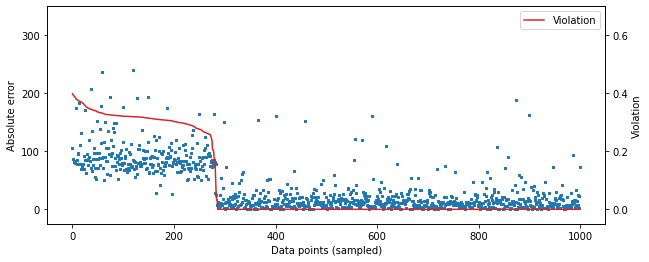

In [12]:
plt.close()
fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.scatter(np.arange(temp.shape[0]), temp["MAE"], color="C0", marker="s", s=2, label="Absolute error")
plt.ylim([-25, 350])
plt.yticks(np.arange(0, 350, 100))
plt.ylabel("Absolute error")
plt.xlabel("Data points (sampled)")

tx = plt.twinx()
tx.plot(np.arange(temp.shape[0]), temp["violation"], color="C3", label="Violation")
tx.set_ylim([-0.05, 0.7])
tx.set_yticks(np.arange(0, 0.7, 0.2))
tx.set_ylabel("Violation")
tx.legend()

plt.legend()
plt.savefig(os.path.join("airline.pdf"), bbox_inches="tight")
plt.show()
